In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

# dickey fuller test for stationarity check
from statsmodels.tsa.stattools import adfuller,acf,pacf

from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pmdarima.arima import auto_arima
from pmdarima.arima import auto_arima
import pmdarima as pm
from pmdarima.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

# Furniture Sales Forecast
Every business owner’s objective is to estimate the future trends – in terms of sales, profits, gains etc. To do this analysis, the owner first has to segregate the data by category and analyze each entity separately. For each entity, a forecast can be estimated based on the past sales of that entity. The idea behind this is to find out the popularity of a certain product and how its sales can impact the business.
Every product category is unique and cater to different customer base. So the analysis cannot be generalized that one trend is applicable to all products. A thorough insight into the past performance will reveal a lot of components that will enable the business to identify the trends.

In [2]:
data=pd.read_excel("DS3_C6_S4_TimeSeries_Sales_Data_Project.csv.xls")
data.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9994 non-null   int64         
 1   Order ID       9994 non-null   object        
 2   Order Date     9994 non-null   datetime64[ns]
 3   Ship Date      9994 non-null   datetime64[ns]
 4   Ship Mode      9994 non-null   object        
 5   Customer ID    9994 non-null   object        
 6   Customer Name  9994 non-null   object        
 7   Segment        9994 non-null   object        
 8   Country        9994 non-null   object        
 9   City           9994 non-null   object        
 10  State          9994 non-null   object        
 11  Postal Code    9994 non-null   int64         
 12  Region         9994 non-null   object        
 13  Product ID     9994 non-null   object        
 14  Category       9994 non-null   object        
 15  Sub-Category   9994 n

<b>Interpretation:
- Data has 8 object type, 6 numeric and 2 datetime coloumns.

In [4]:
data.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,55190.379428,229.858001,3.789574,0.156203,28.656896
std,2885.163629,32063.693350,623.245101,2.225110,0.206452,234.260108
min,1.000000,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,99301.000000,22638.480000,14.000000,0.800000,8399.976000


<b>There is huge difference in mean and median of profit and sales which shows  profit varies a lot across diff time . 

In [5]:
data['Category'].value_counts()

Office Supplies    6026
Furniture          2121
Technology         1847
Name: Category, dtype: int64

<b>Filtering with respect to category

In [6]:
df= data.loc[data['Category']=='Furniture']

In [7]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
5,6,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
10,11,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092


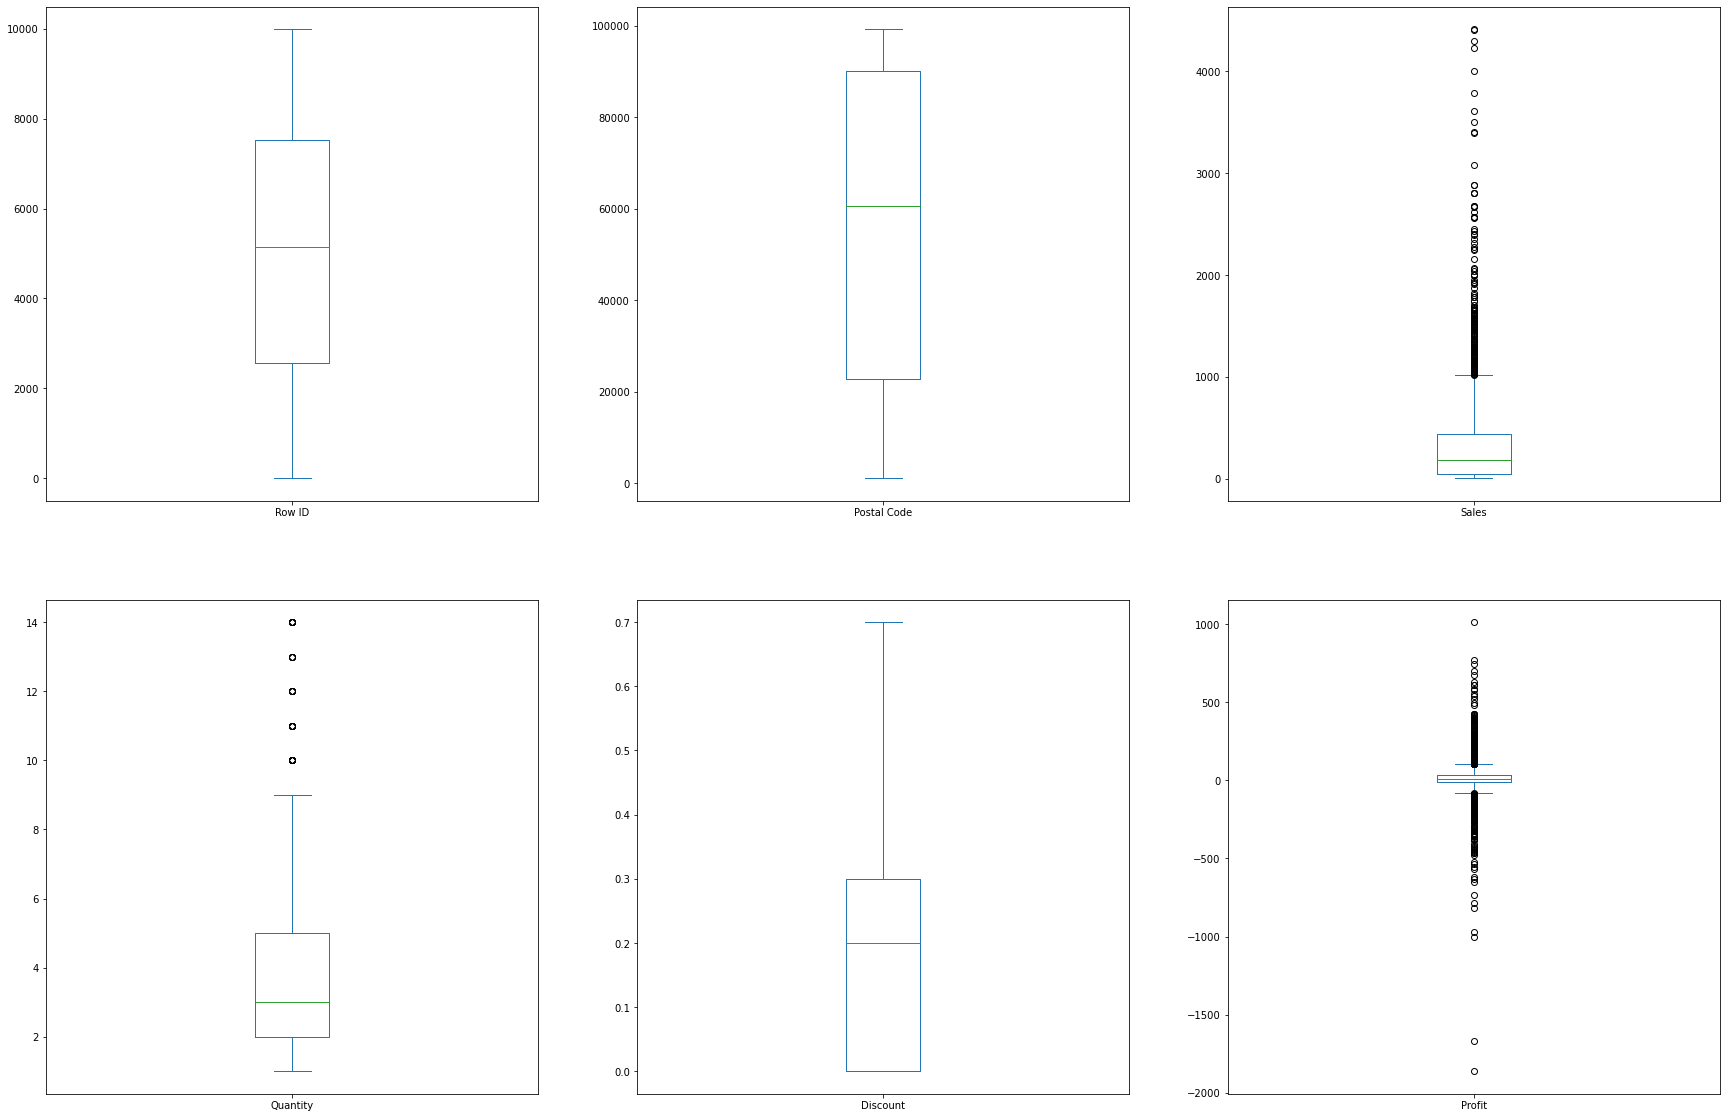

In [8]:
df.plot(kind='box', subplots=True, layout=(2,3), figsize=(30,20))
plt.show()

<AxesSubplot:title={'center':'Sales vs Profit'}, xlabel='Sales', ylabel='Profit'>

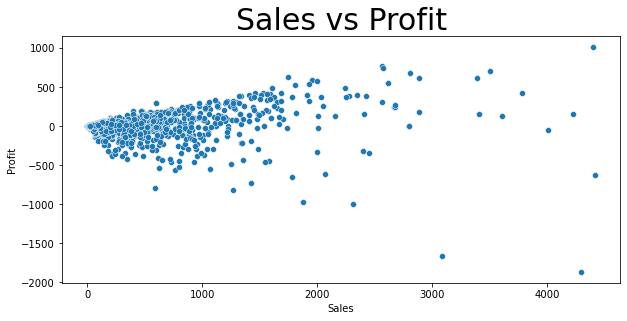

In [9]:
import seaborn as sns
plt.figure(figsize=(10,10))
plt.subplot(2,1,2)
plt.title("Sales vs Profit",fontsize= 30)
sns.scatterplot(x=df['Sales'], y=df['Profit'])

- <b>Sales vs profit shows that profit is ranging around 0-500 when there is sales upto 1000 , post that as sales increases profit is increasing but those observations are very less , majority sales value lies upto 1000

<AxesSubplot:title={'center':'Sales vs Discount'}, xlabel='Discount', ylabel='Sales'>

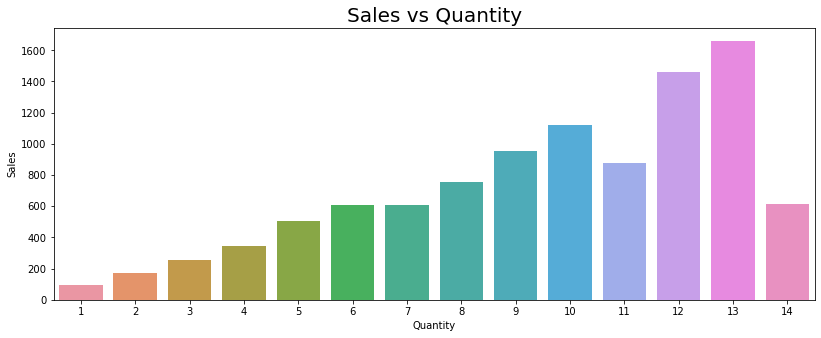

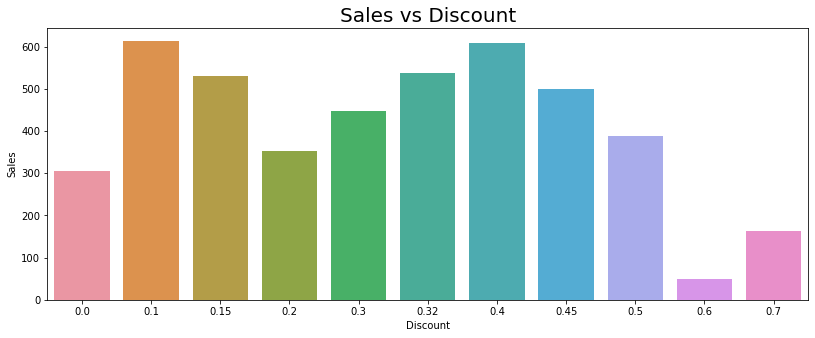

In [10]:
plt.figure(figsize=(30,5))
plt.subplot(121)
plt.title("Sales vs Quantity",fontsize= 20)
sns.barplot(y=df['Sales'], x=df['Quantity'],ci= None)
plt.figure(figsize=(30,5))
plt.subplot(122)
plt.title("Sales vs Discount",fontsize= 20)
sns.barplot(y=df['Sales'], x=df['Discount'],ci= None)

- <b>Sales is maximum when quantity is 13 and increasing from 1 to 13 and surprisingly decreasing when quantity is 14
- <b>With discount has no linear pattern , it has no trend as such. 

In [11]:
df['Order Date'].min(), df['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

In [12]:
#checking null values
df.isnull().sum()

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

<b>Dataset has no missing or null values

In [13]:
# Taking sales , discount and profit for further analysis
df= df.groupby("Order Date")['Sales','Discount','Profit'].sum().reset_index()
df.head()

,Order Date,Sales,Discount,Profit
0,2014-01-06,2573.820,0.00,746.4078
1,2014-01-07,76.728,0.60,-53.7096
2,2014-01-10,51.940,0.00,21.2954
3,2014-01-11,9.940,0.00,3.0814
4,2014-01-13,879.939,0.15,91.2798


In [14]:
df["Order Date"] = pd.to_datetime(df["Order Date"])
df.set_index("Order Date", inplace = True)
df.head()

,Sales,Discount,Profit
Order Date,,,
2014-01-06,2573.820,0.00,746.4078
2014-01-07,76.728,0.60,-53.7096
2014-01-10,51.940,0.00,21.2954
2014-01-11,9.940,0.00,3.0814
2014-01-13,879.939,0.15,91.2798


### Data inspection on whether the data is ready for a time-series analysis. If not, then make the data be able to perform a time-series analysis.

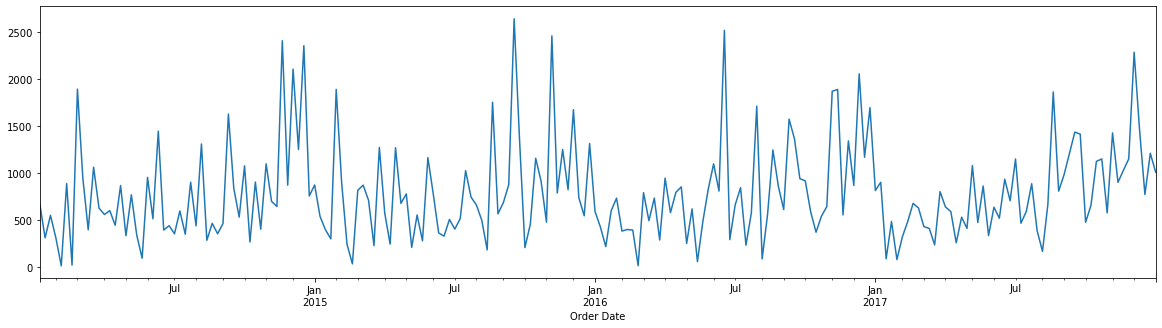

In [15]:
plt.figure(figsize=(20,5))
resample=df["Sales"].resample("W")# montly
w_mean=resample.mean()
w_mean.plot()
plt.show()

In [16]:
df1= df.resample('W').mean() #Weekly mean Month Start
df1.head()

,Sales,Discount,Profit
Order Date,,,
2014-01-12,678.10700,0.150000,179.26875
2014-01-19,312.61825,0.387500,-63.50110
2014-01-26,551.98600,0.066667,118.54210
2014-02-02,311.83300,0.175000,-6.61520
2014-02-09,14.56000,0.000000,5.53280


### Decomposition of data.

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp=seasonal_decompose(df1.Sales,period=52)

In [18]:
trend=decomp.trend
seasonal=decomp.seasonal
residual=decomp.resid

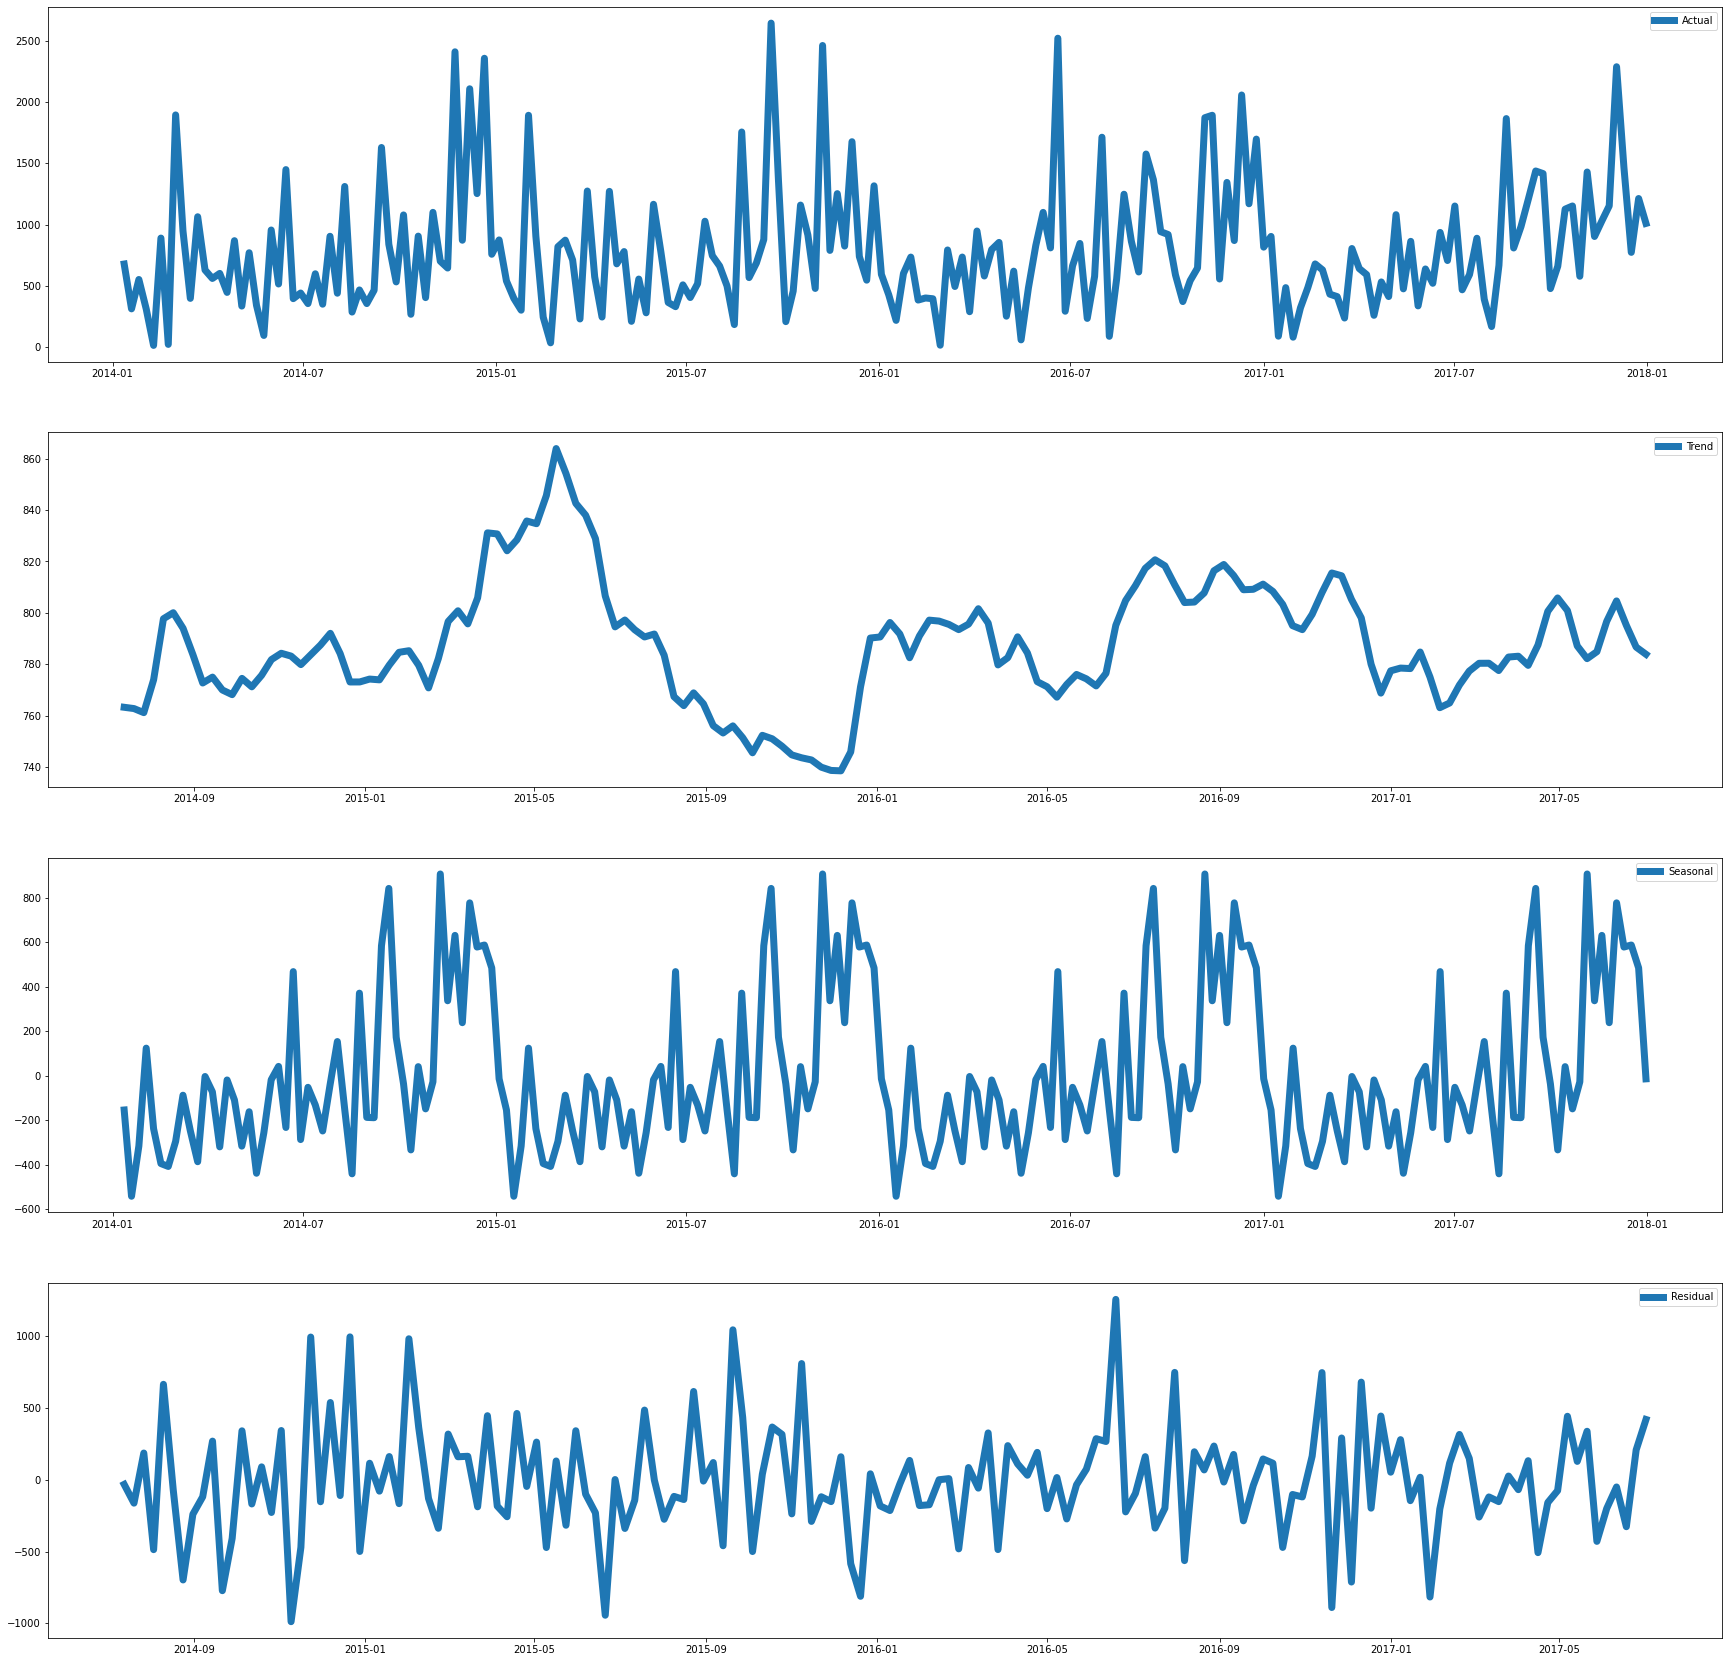

In [19]:
plt.figure(figsize=(30,30))          # Creating subplots of Actual trends seasonal and residual
plt.subplot(4,1,1)
plt.plot(w_mean,label = 'Actual',linewidth=7.0)
plt.legend()

plt.subplot(4,1,2)
plt.plot(trend,label = "Trend",linewidth=7.0)
plt.legend()

plt.subplot(413)
plt.plot(seasonal,label = 'Seasonal',linewidth=7.0)
plt.legend()


plt.subplot(414)
plt.plot(residual,label = 'Residual',linewidth=7.0)
plt.legend()
plt.show()

-<b> By visualizing the decomposition components of the original time series we can say that the sales of furniture is unstable however it shows seasonality and upward trend

### Spiliting the data date wise for training and testing 

In [20]:
train_len=int(0.7*len(df1))
train=df1.iloc[:train_len]
test=df1.iloc[train_len:]
len(train),len(test)

(145, 63)

In [21]:
train['Sales'],test['Sales']

(Order Date
 2014-01-12     678.107000
 2014-01-19     312.618250
 2014-01-26     551.986000
 2014-02-02     311.833000
 2014-02-09      14.560000
                  ...     
 2016-09-18    1364.816000
 2016-09-25     941.591833
 2016-10-02     918.837825
 2016-10-09     589.390000
 2016-10-16     372.037500
 Freq: W-SUN, Name: Sales, Length: 145, dtype: float64,
 Order Date
 2016-10-23     542.777333
 2016-10-30     645.730667
 2016-11-06    1871.214160
 2016-11-13    1891.064333
 2016-11-20     555.995200
                  ...     
 2017-12-03    2286.881714
 2017-12-10    1465.734000
 2017-12-17     773.303167
 2017-12-24    1212.340500
 2017-12-31    1009.391200
 Freq: W-SUN, Name: Sales, Length: 63, dtype: float64)

### Checking Stationarity
our first step in time-series analysis should be to check whether there is any evidence of a trend or seasonal effects and, if there is, remove them. Augmented Dickey-Fuller(ADF) statistic is one of the more widely used statistic test to check whether your time series is stationary or non-stationary. It uses an autoregressive model and optimizes an information criterion across multiple different lag values.

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary(has some time-dependent structure). The alternate hypothesis(rejecting the null hypothesis) is that the time series is stationary.

In [22]:
from statsmodels.tsa.stattools import adfuller

In [23]:
def checkstationarity(data):
    pvalue=adfuller(data)[1]
    if pvalue< 0.05:
        ret='Data is stationary.Do model building'
    else:
        ret='Data is not stationary.Make the data stationary'
    return(ret)

In [24]:
checkstationarity(df1['Sales'])

'Data is stationary.Do model building'

## Ploting ACF and PACF.

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

<Figure size 1440x360 with 0 Axes>

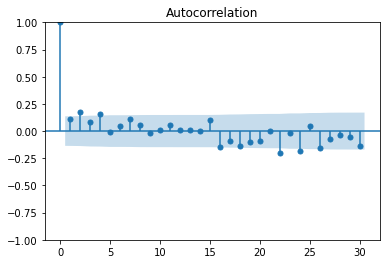

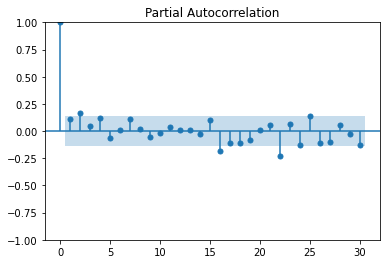

In [26]:
plt.figure(figsize=(20,5))
plot_acf(df1["Sales"],lags=30)
plot_pacf(df1["Sales"],lags=30)
plt.show()

<b>Here p is 3 and q is 4 , observing from the graph

In [27]:
from statsmodels.tsa.arima.model import ARIMA

In [28]:
li=[]
for i in range(3):
    for j in range(4):
        li.append((i,0,j)) # taking d = 0 since it is arma 
li

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 0, 3),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 0, 3)]

## SARIMA

In [29]:
import statsmodels.api as sm

In [30]:
li=[]
for i in range(3):
    for j in range(4):
        li.append((i,0,j)) # taking d = 0 since it is arma 
li

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 0, 3),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 0, 3)]

In [31]:
modelsm=[]
for i in range(3):
    for j in range(4): 
        m = sm.tsa.statespace.SARIMAX(train["Sales"],order=(i,0,j) ,seasonal_order=(i,0,j,52)).fit()
        modelsm.append(m)
modelsm

In [32]:
from sklearn.metrics import mean_squared_error
MSE=[]
RMSE=[]

for i in modelsm:
    forecast=i.fittedvalues
    mse=mean_squared_error(train["Sales"],forecast)
    rmse=mean_squared_error(train["Sales"],forecast,squared=False)
    MSE.append(mse)
    RMSE.append(rmse)

In [33]:
d1=pd.DataFrame({"MSE":MSE,"RMSE":RMSE},index=li)
d1

,MSE,RMSE
"(0, 0, 0)",848028.637710,920.884704
"(0, 0, 1)",539790.313574,734.704235
"(0, 0, 2)",455841.759449,675.160543
"(0, 0, 3)",415264.133496,644.409911
"(1, 0, 0)",447443.682059,668.912313
"(1, 0, 1)",280263.580313,529.399264
"(1, 0, 2)",280551.539331,529.671162
"(1, 0, 3)",277383.197693,526.671812
"(2, 0, 0)",351809.842873,593.135602
"(2, 0, 1)",282070.255065,531.102867


In [34]:
print("minimum MSE = ",d1["MSE"].idxmin())
print("minimum RMSE = ",d1["RMSE"].idxmin())

minimum MSE =  (1, 0, 3)
minimum RMSE =  (1, 0, 3)


In [35]:
# values for p and q based on cross-validation
p=1; d=0; q=3
m2 = sm.tsa.statespace.SARIMAX(train["Sales"],order=(p,d,q),seasonal_order=(p,d,q,52)).fit()

In [36]:
m2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                  145
Model:             SARIMAX(1, 0, 3)x(1, 0, 3, 52)   Log Likelihood               -1114.816
Date:                            Sun, 29 Jan 2023   AIC                           2247.631
Time:                                    02:14:06   BIC                           2274.422
Sample:                                01-12-2014   HQIC                          2258.517
                                     - 10-16-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9999      0.013     76.092      0.000       0.974       1.026
ma.L1         -0.9941      0.120     -8.302      0.000      -1.229      -0.759
ma.L2          0.1117      0.153      0.732      0.464      -0.187       0.411
ma.L3         -0.1055      0.088     -1.197      0.231      -0.278       0.067
ar.S.L52       0.9990     48.837      0.020      0.984     -94.720      96.718
ma.S.L52      -0.8680     49.163     -0.018      0.986     -97.226      95.491
ma.S.L104     -0.0121      6.823     -0.002      0.999     -13.386      13.362
ma.S.L156     -0.1188      3.309     -0.036      0.971      -6.604       6.367
sigma2      2.724e+05      0.001   3.53e+08      0.000    2.72e+05    2.72e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                83.39
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                             1.41
Prob(H) (two-sided):                  0.66   Kurtosis:                         5.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.16e+26. Standard errors may be unstable.
"""

In [37]:
# prediction using test data 
forecast2= m2.forecast(len(test['Sales']))
forecast2

2016-10-23    744.975221
2016-10-30    713.260264
2016-11-06    979.883537
2016-11-13    759.966134
2016-11-20    990.160933
                 ...    
2017-12-03    850.753959
2017-12-10    755.118576
2017-12-17    713.798563
2017-12-24    831.115189
2017-12-31    744.591726
Freq: W-SUN, Name: predicted_mean, Length: 63, dtype: float64

In [38]:
m_s= pd.DataFrame({'actual':test["Sales"],'forecast':forecast2})
m_s

,actual,forecast
2016-10-23,542.777333,744.975221
2016-10-30,645.730667,713.260264
2016-11-06,1871.214160,979.883537
2016-11-13,1891.064333,759.966134
2016-11-20,555.995200,990.160933
...,...,...
2017-12-03,2286.881714,850.753959
2017-12-10,1465.734000,755.118576
2017-12-17,773.303167,713.798563
2017-12-24,1212.340500,831.115189


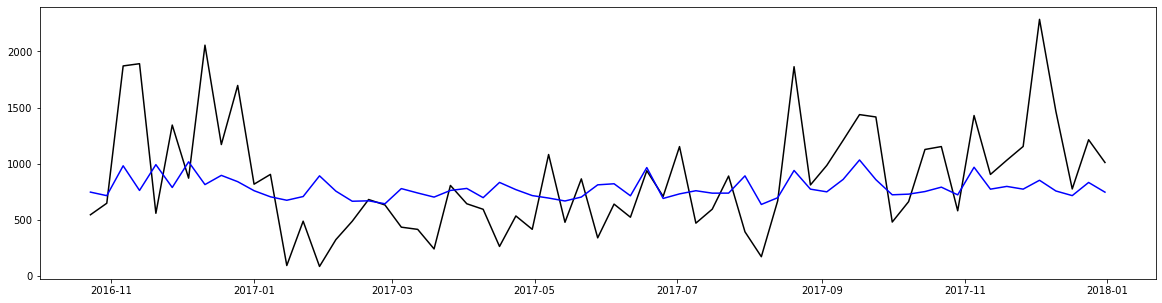

In [39]:
plt.figure(figsize=(20,5))
plt.plot(m_s["actual"],label='actual',c= 'black')
plt.plot(m_s["forecast"],label='Forecast',c= 'blue')
plt.show()

In [40]:
mse2=mean_squared_error(test["Sales"],forecast2)
rmse2=mean_squared_error(test["Sales"],forecast2,squared=False)
aic2= m2.aic
bic2= m2.bic

print(mse2)
print(rmse2)
print(aic2)
print(bic2)

216099.63564785497
464.86518007682076
2247.6313734183223
2274.4219771001076


In [42]:
from statsmodels.tsa.statespace.sarimax import SARIMAX 

In [43]:
exog_train = train[['Profit','Discount']]
exog_test = test[['Profit','Discount']]

In [44]:
li=[]
for i in range(3):
    for j in range(4):
        li.append((i,0,j)) # taking d = 0 since it is arma 
li

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 0, 3),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 0, 3)]

In [45]:
modelsmx=[]
for i in range(3):
    for j in range(4): 
        m = SARIMAX(train.Sales,order=(i,0,j),seasonal_order=(i,0,j,52),exog= exog_train).fit()
        modelsmx.append(m)
modelsmx

In [46]:
from sklearn.metrics import mean_squared_error
aic_v=[]
bic_v=[]

for i in modelsmx:
    aic_v.append(i.aic)
    bic_v.append(i.bic)
    

In [47]:
d2=pd.DataFrame({"AIC":aic_v,"BIC":bic_v},index=li)
d2

,AIC,BIC
"(0, 0, 0)",2174.928111,2183.858313
"(0, 0, 1)",2177.939752,2192.823421
"(0, 0, 2)",2171.625253,2192.462390
"(0, 0, 3)",2175.776192,2202.566796
"(1, 0, 0)",2178.350735,2193.234404
"(1, 0, 1)",2178.296624,2199.133760
"(1, 0, 2)",2175.747312,2202.537916
"(1, 0, 3)",2177.170320,2209.914391
"(2, 0, 0)",2172.479157,2193.316294
"(2, 0, 1)",2175.923007,2202.713610


In [48]:
print("minimum aic = ",d2["AIC"].idxmin())
print("minimum bic = ",d2["BIC"].idxmin())

minimum aic =  (0, 0, 2)
minimum bic =  (0, 0, 0)


In [49]:
sarimax_model = SARIMAX(train.Sales,order=(0,0,2),seasonal_order=(0,0,2,52),exog= exog_train).fit()

In [50]:
pvalue = sm.stats.acorr_ljungbox(sarimax_model.resid,lags=[1],return_df=True)['lb_pvalue'].values 

if pvalue < 0.05:
    print('It is not a good Model')
else :
    print('It is a Good Model')

It is a Good Model


In [51]:
forecast_sarima = sarimax_model.fittedvalues 
forecast_sarima

Order Date
2014-01-12     628.170406
2014-01-19     552.839122
2014-01-26     386.559855
2014-02-02     316.927351
2014-02-09     -23.336674
                 ...     
2016-09-18    1320.454686
2016-09-25    1160.794665
2016-10-02     538.116847
2016-10-09     983.801770
2016-10-16    1218.102084
Freq: W-SUN, Length: 145, dtype: float64

In [53]:
sarimax_forecast1 = sarimax_model.forecast(len(test), exog=exog_test.values)
sarimax_forecast1

2016-10-23     961.468614
2016-10-30    1196.669612
2016-11-06    1642.581951
2016-11-13    1058.850259
2016-11-20    1488.408151
                 ...     
2017-12-03    1682.867596
2017-12-10    1100.816610
2017-12-17    1112.740328
2017-12-24    1138.534915
2017-12-31    1634.665522
Freq: W-SUN, Name: predicted_mean, Length: 63, dtype: float64

In [54]:
m_sarimax= pd.DataFrame({'actual':test["Sales"],'forecast':sarimax_forecast1})
m_sarimax

,actual,forecast
2016-10-23,542.777333,961.468614
2016-10-30,645.730667,1196.669612
2016-11-06,1871.214160,1642.581951
2016-11-13,1891.064333,1058.850259
2016-11-20,555.995200,1488.408151
...,...,...
2017-12-03,2286.881714,1682.867596
2017-12-10,1465.734000,1100.816610
2017-12-17,773.303167,1112.740328
2017-12-24,1212.340500,1138.534915


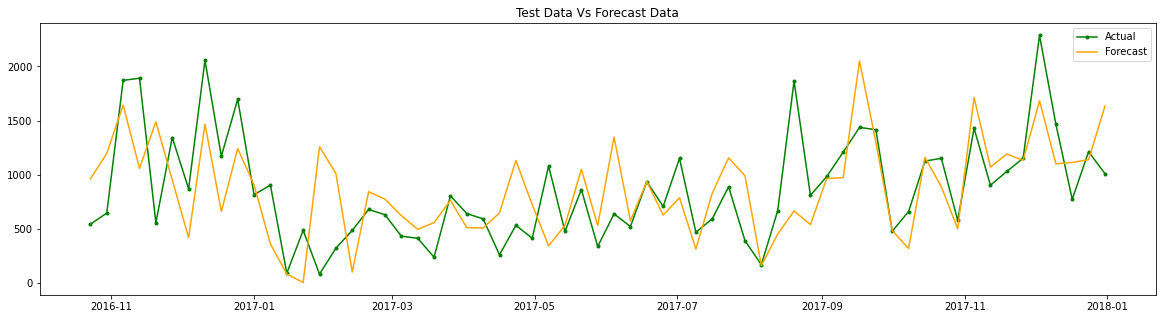

In [55]:
plt.figure(figsize=(20,5))
plt.title('Test Data Vs Forecast Data')
plt.plot(test['Sales'],marker = '.', color = 'Green' , label = 'Actual')
plt.plot(sarimax_forecast1,color = 'orange' , label = 'Forecast' )
plt.legend()
plt.show()

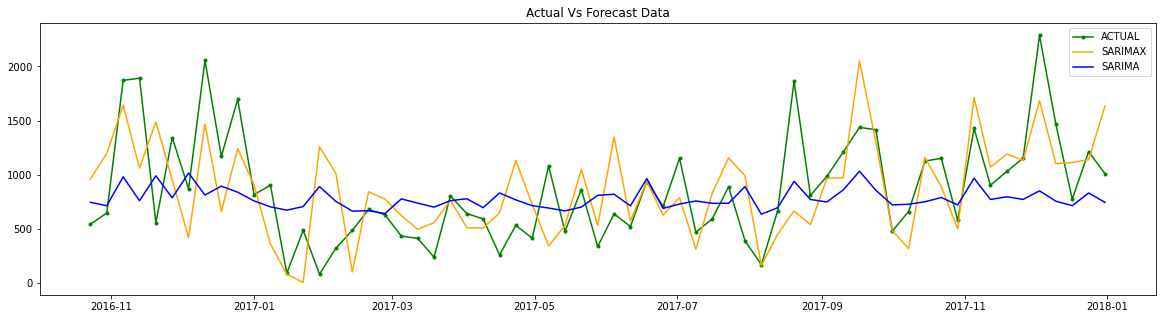

In [57]:
plt.figure(figsize=(20,5))
plt.title('Actual Vs Forecast Data')
plt.plot(test['Sales'],marker = '.', color = 'Green' , label = 'ACTUAL')
plt.plot(sarimax_forecast1,color = 'orange' , label = 'SARIMAX' )
plt.plot(forecast2,label='SARIMA',c= 'blue')
plt.legend()
plt.show()

- <b>Comparing the AIC score of all the model and visualization ,Sarimax is best model amongst all the model 